# Dogs vs. Cats

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8486636018403487992
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 5750272000
locality {
  bus_id: 1
}
incarnation: 4775782305672251113
physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:02:00.0"
]


https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
import numpy as np
import keras
import gc
from keras.models import Model
from keras.preprocessing.image import load_img, img_to_array

Using TensorFlow backend.


In [4]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

In [5]:
IMG_SIZE = (224, 224)  # размер входного изображения сети

## Функции загрузки данных

In [176]:
import re
from random import shuffle
from glob import glob

train_files = glob('./train/*.jpg')
test_files = glob('./test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = load_img(path, target_size=target_size)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    return preprocess_input(array)  # предобработка для VGG16

# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, batch_size=32):
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            #y = np.array([1. if re.match('.*/dog\.\d+.*', path) else 0. for path in files[i:j]])
            y = np.array([1. if re.findall('dog', path) else 0. for path in files[i:j]])
            #print( path)
            yield (x, y)

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

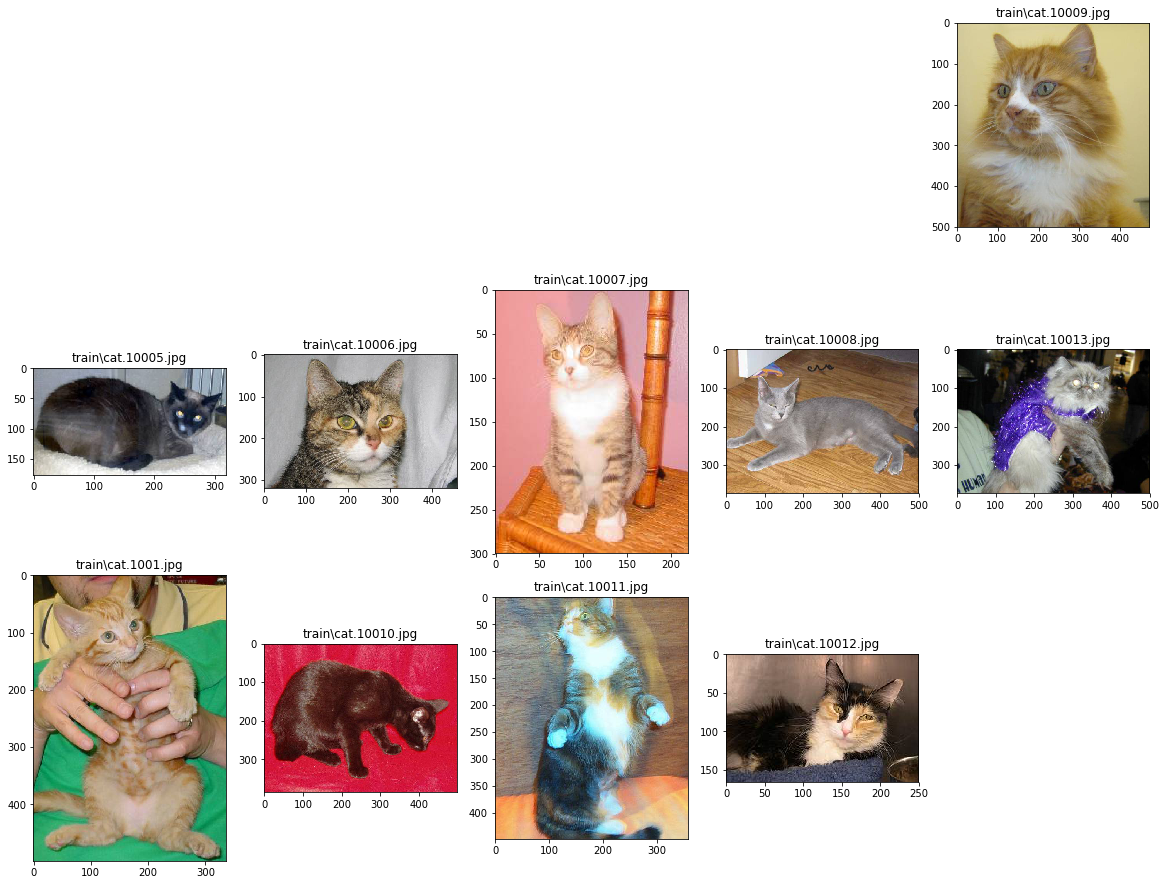

In [177]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, path in enumerate(train_files[10:20], 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%s' % path.split('/')[-1]);

## Загружаем предобученную модель

In [178]:
# base_model -  объект класса keras.models.Model (Functional Model)
base_model = VGG16(include_top = False,weights = 'imagenet',
                   input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))

In [179]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:#[:15]:
    #print(layer.name)
    layer.trainable = False

In [180]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Добавляем полносвязанные слои

In [181]:
x = base_model.output
# x = keras.layers.Conv2D(256,
#                         (3,3),
#                         activation='relu', 
#                         name='block6_conv1')(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(rate=0.3,seed=255)(x)
#x = keras.layers.Dropout(rate=0.1,seed=243)(x)
# x = keras.layers.Dense(1000,
#                        activation='relu', 
#                        name='block6_ds1')(x)
# x = keras.layers.Dropout(rate=0.2,seed=248)(x)
x = keras.layers.Dense(1,  # один выход
                       activation='sigmoid',  # функция активации
                       name='ds-out',
                       #kernel_regularizer=keras.regularizers.l1(1e-4)
                      )(x)
model = Model(inputs=base_model.input, outputs=x)

In [182]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [183]:
## Компилируем модель и запускаем обучение

In [184]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [185]:
#from keras.callbacks import EarlyStopping # автоостанавливаем
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='best_weights.hdf5', verbose=1, save_best_only=True, period=2)

#early_stopping = EarlyStopping(monitor='val_loss', patience=3)

shuffle(train_files)  # перемешиваем обучающую выборку

train_val_split = 100  # число изображений в валидационной выборке

validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))

#model.evaluate(X_test, Y_test, verbose=1)

In [ ]:
# запускаем процесс обучения
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
                    steps_per_epoch=64,  # число вызовов генератора за эпоху
                    epochs=30,  # число эпох обучения
                    callbacks=[checkpointer], #автоостанов
                    validation_data=validation_data)

Epoch 1/30
64/64 [==============================] - 20s - loss: 0.8295 - acc: 0.9282 - val_loss: 0.6641 - val_acc: 0.9300
Epoch 2/30
64/64 [==============================] - 20s - loss: 0.6194 - acc: 0.9497 - val_loss: 0.6679 - val_acc: 0.9400
Epoch 3/30
53/64 [=======================>......] - ETA: 5s - loss: 0.5959 - acc: 0.9522

In [30]:
# Грохнем модели в памяти GPU
#del model
#del base_model
#gc.collect()

235

## Визуализируем результат

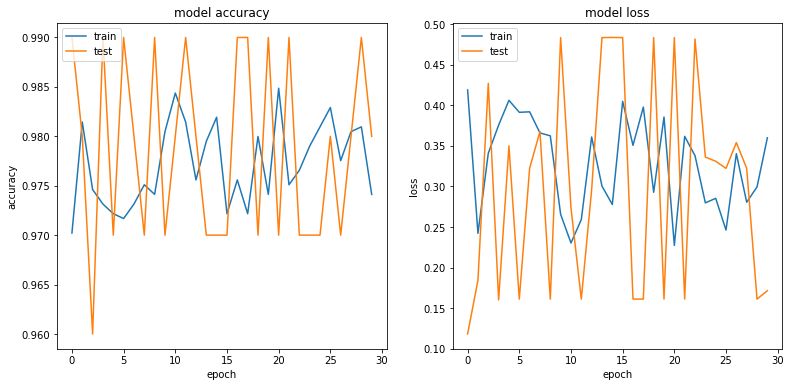

In [139]:
#model.history.history.keys()
from pylab import rcParams
rcParams['figure.figsize'] = 13,6
# summarize history for accuracy
plt.subplot(1,2,1)
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(1,2,2)
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()


In [ ]:
#10 эпох по 10 val_loss=0.4535 acc=0.9600 CG=1.16580
#100 эпох по 10 val_loss=0.4535 acc=0.9600 CG=1.06932
#50  эпох по 5 + up 4 level learn  val_loss: 0.2560 - val_acc: 0.9800  KG=0.86359
#20  эпох по 10 + up 4 level learn  val_loss: 0.1847 - val_acc: 0.9900  KG=0.75441
#20  эпох по 10 + up 3 level learn  val_loss: 0.2954 - val_acc: 0.9800  KG=0.75441
#20  эпох по 10  val_loss: 0.1855 - val_acc: 0.9900 KG=0.77108 
#20  эпох по 10 + изменение данных  val_loss: 0.1855 - val_acc: 0.9900 KG=0.14315 
#10  эпох 20 val_loss: 0.2148 - val_acc: 0.9900 KG

## Предсказания на проверочной выборке

In [140]:
#загрузим лучшую модель
# identical to the previous one
from keras.models import load_model
model = load_model('best_weights.hdf5')

In [141]:
%%time
pred = model.predict_generator(predict_generator(test_files), len(test_files), max_queue_size=500)

Wall time: 3min 25s


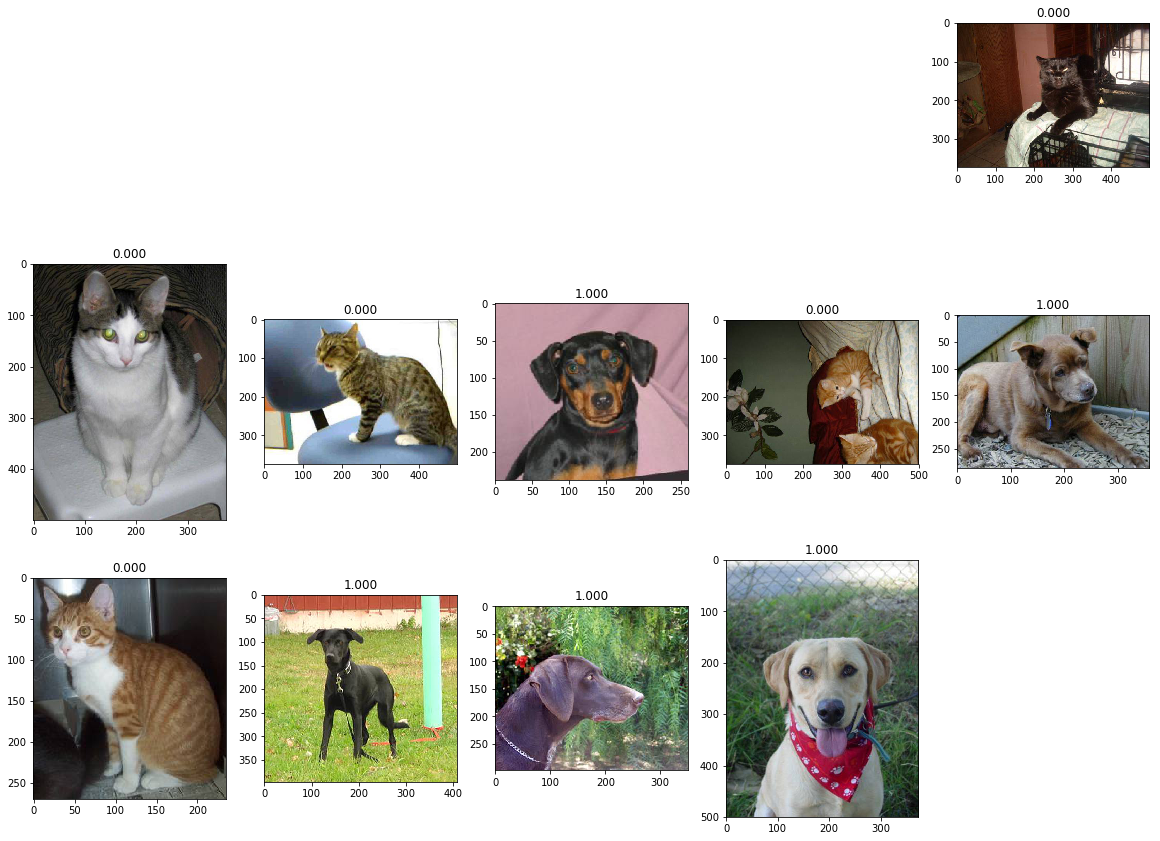

In [142]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, (path, score) in enumerate(zip(test_files[90:][:10], pred[90:][:10]), 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%.3f' % score);

## Готовим данные для сабмита

In [143]:
pred= np.clip(pred,0.0125,0.9875)

In [144]:
with open('submit.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, pred):
        #if score<0.001:
        #    score=0

        dst.write('%s,%3f\n' % (re.search('(\d+)', path).group(0), score))

In [100]:
# LogLoss = 1.04979

In [ ]:
for path, score in zip(test_files, pred):
    num=re.search('(\d+)', path).group(0)
    print(path, score, num)